# Evaluation of Meta Model

In [1]:
import arrow
import learn2learn as l2l
import numpy as np
import os
import pickle
import torch
from torch.nn import Module, Linear, Sequential, ReLU
from torch.nn.functional import mse_loss
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.evalUtils import print_confusion_matrix

from sklearn.preprocessing import MinMaxScaler

In [2]:
%run -i ./scripts/setConfigs.py

Set configs..


## Prepare Data for PyTorch
### Read data
#### Read X_test

In [3]:
data_fn = os.path.join(data_path, 'anomalous_data_y_2022_reduced.h5')
df_data_X_test = pd.read_hdf(data_fn, key='df')
print('Shape of X_test data: {}'.format(df_data_X_test.shape))

Shape of X_test data: (35040, 18)


In [4]:
s_ano_labels_X_test = df_data_X_test['label']
s_ano_labels_X_test.reset_index(drop=True, inplace=True)
df_data_X_test.drop('label', axis=1, inplace=True)
print('Shape of X_test data: {}'.format(df_data_X_test.shape))

Shape of X_test data: (35040, 17)


#### Read X_drifted

In [5]:
fn = os.path.join(data_path, 'drifted_data_y_2023_reduced_more_cos_phi.h5')
df_data_X_drifted = pd.read_hdf(fn, key='df')
print('Shape of X_drifted data: {}'.format(df_data_X_drifted.shape))

Shape of X_drifted data: (35040, 18)


In [6]:
s_drift_labels_X_drifted = df_data_X_drifted['drift_labels']
s_drift_labels_X_drifted.reset_index(drop=True, inplace=True)
df_data_X_drifted.drop('drift_labels', axis=1, inplace=True)
print('Shape of X_drifted data: {}'.format(df_data_X_drifted.shape))

Shape of X_drifted data: (35040, 17)


In [7]:
print('Drift Labels: {}'.format(sorted(s_drift_labels_X_drifted.unique())))

Drift Labels: [0.0, 1.0, 2.0, 3.0]


#### Read X_drifted,ano

In [8]:
fn = os.path.join(data_path, 'anomalous_drifted_data_y_2023_reduced_more_cos_phi.h5')
df_data_X_drifted_ano = pd.read_hdf(fn, key='df')
print('Shape of X_drifted,ano data: {}'.format(df_data_X_drifted_ano.shape))

Shape of X_drifted,ano data: (35040, 19)


In [9]:
s_drift_labels_X_drifted_ano = df_data_X_drifted_ano['drift_labels']
s_drift_labels_X_drifted_ano.reset_index(drop=True, inplace=True)
df_data_X_drifted_ano.drop('drift_labels', axis=1, inplace=True)
print('Shape of X_drifted,ano data: {}'.format(df_data_X_drifted_ano.shape))

Shape of X_drifted,ano data: (35040, 18)


In [10]:
s_ano_labels_X_drifted_ano = df_data_X_drifted_ano['anomaly_labels']
s_ano_labels_X_drifted_ano.reset_index(drop=True, inplace=True)
df_data_X_drifted_ano.drop('anomaly_labels', axis=1, inplace=True)
print('Shape of X_drifted,ano: {}'.format(df_data_X_drifted_ano.shape))

Shape of X_drifted,ano: (35040, 17)


### Scale data

In [11]:
### Scale data
print('Scale data..')
scaler_train = MinMaxScaler((-1,1))
scaler_train = scaler_train.fit(df_data_X_test)

scaled_X_test = scaler_train.transform(df_data_X_test.to_numpy())
scaled_X_drifted = scaler_train.transform(df_data_X_drifted.to_numpy())
scaled_X_drifted_ano = scaler_train.transform(df_data_X_drifted_ano.to_numpy())

Scale data..


### Build PyTorch objects

In [12]:
# build tensor from numpy for AE
torch_tensor_X_test = torch.from_numpy(scaled_X_test).type(torch.FloatTensor)
dataset_X_test = TensorDataset(torch_tensor_X_test, torch_tensor_X_test)

In [13]:
# build tensor from numpy for AE
torch_tensor_X_drifted = torch.from_numpy(scaled_X_drifted).type(torch.FloatTensor)
dataset_X_drifted = TensorDataset(torch_tensor_X_drifted, torch_tensor_X_drifted)

In [14]:
# build tensor from numpy for AE
torch_tensor_X_drifted_ano = torch.from_numpy(scaled_X_drifted_ano).type(torch.FloatTensor)
dataset_X_drifted_ano = TensorDataset(torch_tensor_X_drifted_ano, torch_tensor_X_drifted_ano)

## Read Models

In [15]:
%run -i ./scripts/ReadSimpleAE_MetaModel.py

Load Meta Model AE..
/home/torge/dev/masterthesis_code/02_Experimente/MetaLearning/models/model_bib/20200317_firstMetaModel.pt
SimpleAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=17, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=8, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=17, bias=True)
    (3): Tanh()
  )
)


In [16]:
%run -i ./scripts/ReadLogReg_Meta.py

Load trained LogReg..
LogisticRegression(C=1.0, class_weight={1: 2.0}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


/home/torge/anaconda3/envs/ma_modells/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Predict Anomalies on every dataset X_test, X_drifted, X_drifted,ano

#### On X_test dataset with Meta-Model

In [17]:
re_X_test = []
for val in torch_tensor_X_test:
    loss = meta_model.calc_reconstruction_error(val)
    re_X_test.append(loss.item())
    
s_re_X_test = pd.Series(re_X_test)

In [18]:
X_X_test = s_re_X_test.to_numpy()
X_X_test = X_X_test.reshape(-1, 1)
y_X_test = [1 if x > 0 else 0 for x in s_ano_labels_X_test]

In [19]:
predictions_X_test = []
for val in X_X_test:
    val = val.reshape(1,-1)
    pred = clf_meta.predict(val)
    predictions_X_test.append(pred[0])

### On X_drifted with Meta-Model

In [20]:
re_X_drifted = []
for val in torch_tensor_X_drifted:
    loss = meta_model.calc_reconstruction_error(val)
    re_X_drifted.append(loss.item())
    
s_re_X_drifted = pd.Series(re_X_drifted)

In [21]:
X_X_drifted = s_re_X_drifted.to_numpy()
X_X_drifted = X_X_drifted.reshape(-1, 1)
y_X_drifted = np.zeros(len(X_X_drifted))

In [22]:
predictions_X_drifted = []
for val in X_X_drifted:
    val = val.reshape(1,-1)
    pred = clf_meta.predict(val)
    predictions_X_drifted.append(pred[0])

### On X_drifted,ano with Meta-Model

In [23]:
re_X_drifted_ano = []
for val in torch_tensor_X_drifted_ano:
    loss = meta_model.calc_reconstruction_error(val)
    re_X_drifted_ano.append(loss.item())
    
s_re_X_drifted_ano = pd.Series(re_X_drifted_ano)

In [24]:
X_X_drifted_ano = s_re_X_drifted_ano.to_numpy()
X_X_drifted_ano = X_X_drifted_ano.reshape(-1, 1)
y_X_drifted_ano = [1 if x > 0 else 0 for x in s_ano_labels_X_drifted_ano]

In [25]:
predictions_X_drifted_ano = []
for val in X_X_drifted_ano:
    val = val.reshape(1,-1)
    pred = clf_meta.predict(val)
    predictions_X_drifted_ano.append(pred[0])

## Calculate KPIs

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from mlxtend.plotting import plot_confusion_matrix
from utils.evalUtils import calc_cm_metrics

import joblib

### For X_test

In [27]:
cm_X_test = confusion_matrix(y_X_test, predictions_X_test)
tn_X_test, fp_X_test, fn_X_test, tp_X_test  = confusion_matrix(y_X_test, predictions_X_test).ravel()

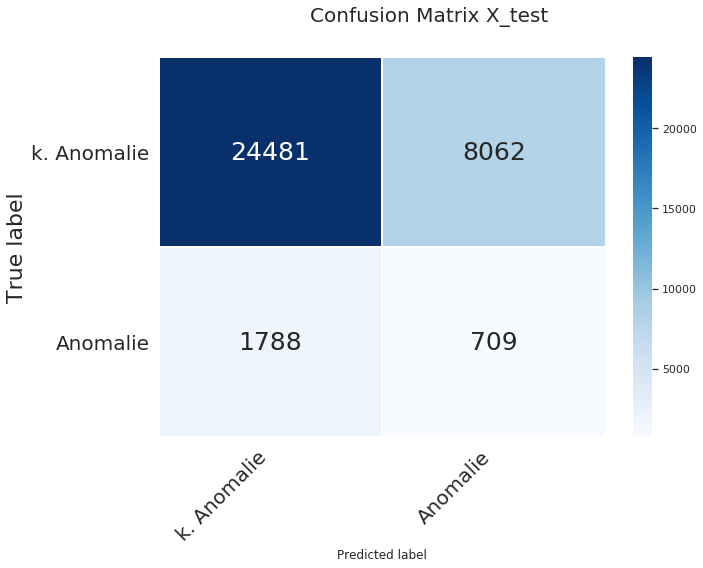

In [28]:
fig = print_confusion_matrix(cm_X_test, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix X_test', fontsize=20)
fn = os.path.join(fig_path, 'cm_ano_x_test.pdf')
fig.savefig(fn, bbox_inches = 'tight', pad_inches = 0 )

In [29]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp_X_test, tn_X_test, fp_X_test, fn_X_test)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 71.88926940637218
Precision: 8.083456846416505
Specifity: 97.18539102814721
Sensitivity: 28.394072887351246
F1-Score: 12.584309549154609


### For X_drifted

In [30]:
cm_X_drifted = confusion_matrix(y_X_drifted, predictions_X_drifted)
tn_X_drifted, fp_X_drifted, fn_X_drifted, tp_X_drifted  = cm_X_drifted.ravel()

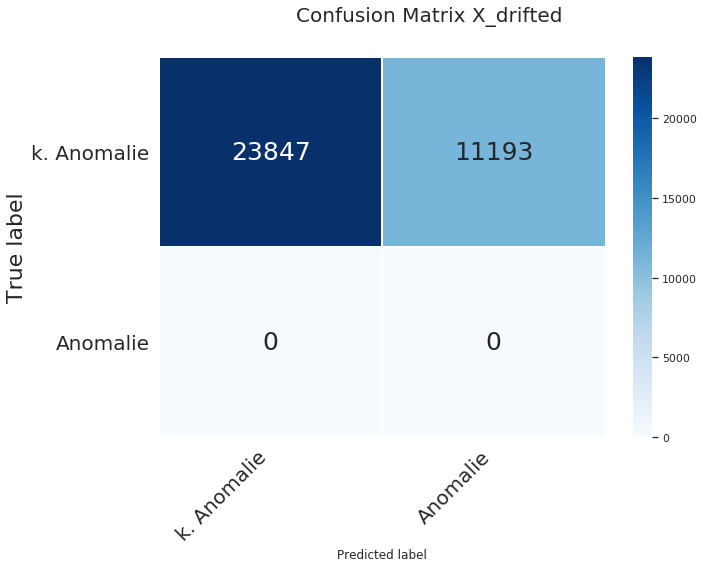

In [31]:
fig = print_confusion_matrix(cm_X_drifted, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix X_drifted', fontsize=20)
fn = os.path.join(fig_path, 'cm_ano_x_drifted.pdf')
fig.savefig(fn, bbox_inches = 'tight', pad_inches = 0 )

In [32]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp_X_drifted, tn_X_drifted, fp_X_drifted, fn_X_drifted)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 68.05650684929564
Precision: 0.0
Specifity: 99.99999999995806
Sensitivity: 0.0
F1-Score: 0.0


### For X_drifted,ano

In [33]:
cm_X_drifted_ano = confusion_matrix(y_X_drifted_ano, predictions_X_drifted_ano)
tn_X_drifted_ano, fp_X_drifted_ano, fn_X_drifted_ano, tp_X_drifted_ano  = cm_X_drifted_ano.ravel()

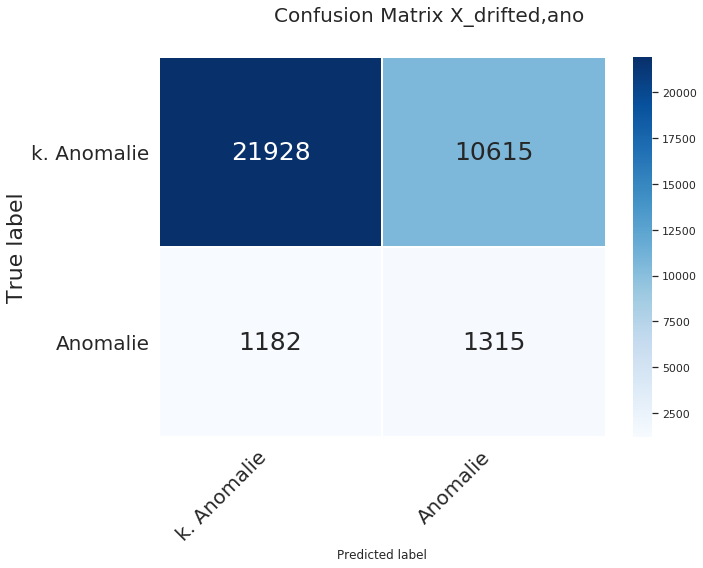

In [34]:
fig = print_confusion_matrix(cm_X_drifted_ano, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix X_drifted,ano', fontsize=20)
fn = os.path.join(fig_path, 'cm_ano_x_drifted_ano.pdf')
fig.savefig(fn, bbox_inches = 'tight', pad_inches = 0 )

In [35]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp_X_drifted_ano, tn_X_drifted_ano, fp_X_drifted_ano, fn_X_drifted_ano)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 66.3327625570587
Precision: 11.02263202010811
Specifity: 94.34238265280112
Sensitivity: 52.6631958347911
F1-Score: 18.229708186027427
